# 05. Supervised Fine-Tuning (SFT)
## Synthetic Instruction Tuner - Week 3 Day 1-3

This notebook performs supervised fine-tuning on the filtered instruction dataset:
1. Load base model (Llama-3.2-3B)
2. Prepare SFT training data
3. Configure LoRA for parameter-efficient fine-tuning
4. Train with TRL's SFTTrainer
5. Evaluate and save the fine-tuned model

**Training settings (A100 GPU optimized)**:
- LoRA: r=8, alpha=16
- Epochs: 3
- Learning rate: 2e-4
- Batch size: 12 (A100 40GB VRAM)
- Gradient accumulation: 2 (Effective batch size: 24)
- Checkpoint interval: 100 steps
- **BF16 enabled** for optimal A100 performance

**Expected runtime on A100 (Colab Pro)**:
- Total training time: **2-4 hours**
- Checkpoints saved: 1-2 times during training
- Cost: ~10-21 compute units

**GPU Optimization**:
- A100: 12 batch size, BF16 enabled
- Memory usage: ~20-25GB / 40GB (safe margin)
- 2-3x faster than T4

**⚠️ IMPORTANT: Before running this notebook**:
1. Runtime → Change runtime type → GPU type: **A100**
2. Runtime → Restart runtime
3. Verify Cell 6 shows "GPU: NVIDIA A100-SXM4-40GB"

**Tip**: Monitor training loss and checkpoints are auto-saved to Google Drive

## 1. Setup

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Project path
PROJECT_ROOT = "/content/drive/MyDrive/synthetic-instruction-tuner"

Mounted at /content/drive


In [2]:
# Load configuration
import json

with open(f"{PROJECT_ROOT}/config.json", 'r') as f:
    config = json.load(f)

print("Configuration loaded!")

Configuration loaded!


In [3]:
# Configure for A100 GPU
with open(f"{PROJECT_ROOT}/config.json", 'r') as f:
    config = json.load(f)

# A100 optimization settings
config['training']['sft_batch_size'] = 12
config['training']['dpo_batch_size'] = 8
config['training']['gradient_accumulation_steps'] = 2

# Save updated config
with open(f"{PROJECT_ROOT}/config.json", 'w') as f:
    json.dump(config, f, indent=2)

print("✅ A100 GPU settings applied!")
print(f"  Base model: {config['models']['sft_base']}")
print(f"  Batch size: {config['training']['sft_batch_size']}")
print(f"  Gradient accumulation: {config['training']['gradient_accumulation_steps']}")
print(f"  Effective batch size: {config['training']['sft_batch_size'] * config['training']['gradient_accumulation_steps']}")
print(f"  Expected A100 training time: 2-4 hours")

✅ A100 GPU settings applied!
  Base model: meta-llama/Llama-3.2-3B
  Batch size: 12
  Gradient accumulation: 2
  Effective batch size: 24
  Expected A100 training time: 2-4 hours


In [4]:
# Install required libraries
!pip install -q --upgrade transformers>=4.41.0 peft>=0.7.0 trl>=0.7.4 datasets>=2.16.0 accelerate>=0.25.0 bitsandbytes>=0.41.3

print("✅ Libraries installed successfully!")

✅ Libraries installed successfully!


In [5]:
import torch
import json
import os
import time
from datetime import datetime
from datasets import Dataset
import gc

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"GPU: {gpu_name}")
    print(f"GPU Memory: {gpu_memory:.2f} GB")

    # Verify A100
    if "A100" not in gpu_name:
        print("\n⚠️ WARNING: This notebook is optimized for A100 GPU!")
        print(f"   Current GPU: {gpu_name}")
        print("   Please change runtime to A100:")
        print("   Runtime → Change runtime type → GPU type: A100")
    else:
        print("\n✅ A100 GPU detected! Ready for training.")

PyTorch version: 2.9.0+cu126
CUDA available: True
GPU: NVIDIA A100-SXM4-80GB
GPU Memory: 85.17 GB

✅ A100 GPU detected! Ready for training.


In [6]:
# A100 GPU optimization settings
import torch

# Enable BF16 for A100 (supported natively)
torch.backends.cuda.matmul.allow_bf16_reduced_precision_reduction = True
torch.backends.cudnn.allow_tf32 = True

print("=" * 50)
print("A100 GPU Performance Settings:")
print(f"  BF16 enabled: {torch.backends.cuda.matmul.allow_bf16_reduced_precision_reduction}")
print(f"  TF32 enabled: {torch.backends.cudnn.allow_tf32}")
print(f"  Optimal for A100 40GB VRAM")
print("=" * 50)

A100 GPU Performance Settings:
  BF16 enabled: True
  TF32 enabled: True
  Optimal for A100 40GB VRAM


/usr/local/lib/python3.12/dist-packages/torch/backends/__init__.py:46: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  self.setter(val)


In [7]:
# Efficiency Metrics Tracker for Method Comparison
class EfficiencyTracker:
    """Track efficiency metrics for adaptation method comparison."""

    def __init__(self, method_name: str):
        self.method_name = method_name
        self.metrics = {
            "method": method_name,
            "memory_allocated_gb": [],
            "memory_reserved_gb": [],
            "training_time_seconds": 0,
            "trainable_params": 0,
            "total_params": 0,
            "trainable_ratio": 0,
            "inference_tokens_per_sec": 0,
        }
        self.start_time = None

    def log_memory(self):
        """Log current GPU memory usage."""
        if torch.cuda.is_available():
            allocated = torch.cuda.memory_allocated() / 1e9
            reserved = torch.cuda.memory_reserved() / 1e9
            self.metrics["memory_allocated_gb"].append(allocated)
            self.metrics["memory_reserved_gb"].append(reserved)
            return {"allocated": allocated, "reserved": reserved}
        return None

    def start_training(self):
        """Start timing training."""
        self.start_time = time.time()
        self.log_memory()

    def end_training(self):
        """End timing training."""
        if self.start_time:
            self.metrics["training_time_seconds"] = time.time() - self.start_time
        self.log_memory()

    def log_params(self, model):
        """Log parameter counts."""
        trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
        total = sum(p.numel() for p in model.parameters())
        self.metrics["trainable_params"] = trainable
        self.metrics["total_params"] = total
        self.metrics["trainable_ratio"] = trainable / total if total > 0 else 0

    def log_inference_speed(self, tokens_generated: int, time_taken: float):
        """Log inference speed."""
        self.metrics["inference_tokens_per_sec"] = tokens_generated / time_taken if time_taken > 0 else 0

    def get_summary(self):
        """Get summary metrics."""
        summary = {
            "method": self.method_name,
            "trainable_params": self.metrics["trainable_params"],
            "total_params": self.metrics["total_params"],
            "trainable_ratio_percent": self.metrics["trainable_ratio"] * 100,
            "peak_memory_gb": max(self.metrics["memory_allocated_gb"]) if self.metrics["memory_allocated_gb"] else 0,
            "training_time_hours": self.metrics["training_time_seconds"] / 3600,
            "inference_tokens_per_sec": self.metrics["inference_tokens_per_sec"],
        }
        return summary

    def save(self, path: str):
        """Save metrics to JSON."""
        with open(path, 'w') as f:
            json.dump(self.get_summary(), f, indent=2)
        print(f"Metrics saved to {path}")

# Initialize tracker for LoRA
tracker = EfficiencyTracker("lora_r8")
print("Efficiency tracker initialized for LoRA!")

Efficiency tracker initialized for LoRA!


## 2. Load Training Data

In [8]:
# Load SFT training data
TRAIN_PATH = f"{config['paths']['data_filtered']}/sft_train.json"
VAL_PATH = f"{config['paths']['data_filtered']}/sft_val.json"

with open(TRAIN_PATH, 'r', encoding='utf-8') as f:
    train_data = json.load(f)

with open(VAL_PATH, 'r', encoding='utf-8') as f:
    val_data = json.load(f)

print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")

Training samples: 900
Validation samples: 100


In [9]:
# Preview data format
print("Sample training data:")
print(json.dumps(train_data[0], indent=2, ensure_ascii=False)[:500])

Sample training data:
{
  "instruction": "## Step 1: Identify the type of problem\nThe problem is asking for the sum of a specific arithmetic series.\n\n## Step 2: Recall the formula for the sum of an arithmetic series\nThe sum of an arithmetic series can be calculated using the formula S = n/2 * (a + l), where S is the sum of the series, n is the number of terms, a is the first term, and l is the last term.\n\n## Step 3: Identify the number of terms (n) in the series\nSince the series starts with 1 and ends with 100


In [10]:
# Convert to HuggingFace Dataset
train_dataset = Dataset.from_list(train_data)
val_dataset = Dataset.from_list(val_data)

print(f"Train dataset: {train_dataset}")
print(f"Val dataset: {val_dataset}")

Train dataset: Dataset({
    features: ['instruction', 'input', 'output'],
    num_rows: 900
})
Val dataset: Dataset({
    features: ['instruction', 'input', 'output'],
    num_rows: 100
})


## 3. Load Base Model

In [11]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, TrainingArguments
from trl import SFTTrainer

# Set base model ID
BASE_MODEL_ID = config['models']['sft_base']
OUTPUT_DIR = f"{config['paths']['models_sft']}/sft-checkpoint"

print(f"Base model: {BASE_MODEL_ID}")
print(f"Output directory: {OUTPUT_DIR}")

Base model: meta-llama/Llama-3.2-3B
Output directory: /content/drive/MyDrive/synthetic-instruction-tuner/models/sft/sft-checkpoint


In [12]:
# 4-bit quantization for memory efficiency (A100 with BF16)
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,  # BF16 for A100
    bnb_4bit_use_double_quant=True,
)

print("✅ Quantization config created (BF16 for A100 performance)")

✅ Quantization config created (BF16 for A100 performance)


In [13]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_ID)

# Set pad token if not present
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.pad_token_id = tokenizer.eos_token_id

tokenizer.padding_side = "right"  # Important for training

print(f"Tokenizer loaded. Vocab size: {tokenizer.vocab_size}")
print(f"PAD token: {tokenizer.pad_token} (ID: {tokenizer.pad_token_id})")
print(f"EOS token: {tokenizer.eos_token} (ID: {tokenizer.eos_token_id})")

tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

Tokenizer loaded. Vocab size: 128000
PAD token: <|end_of_text|> (ID: 128001)
EOS token: <|end_of_text|> (ID: 128001)


In [15]:
# Load model
model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL_ID,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
)

# Enable gradient checkpointing for memory efficiency
model.config.use_cache = False
model.config.pretraining_tp = 1

# Log memory after model load
mem = tracker.log_memory()
print(f"Model loaded!")
print(f"GPU Memory: {mem['allocated']:.2f} GB allocated, {mem['reserved']:.2f} GB reserved")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Model loaded!
GPU Memory: 4.49 GB allocated, 6.01 GB reserved


## 4. Configure LoRA

In [16]:
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

# Prepare model for k-bit training
model = prepare_model_for_kbit_training(model)

print("Model prepared for k-bit training")

Model prepared for k-bit training


In [17]:
# LoRA configuration
lora_config = LoraConfig(
    r=config['training']['lora_r'],
    lora_alpha=config['training']['lora_alpha'],
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
    ],
    lora_dropout=config['training']['lora_dropout'],
    bias="none",
    task_type="CAUSAL_LM",
)

print("LoRA config:")
print(f"  r: {lora_config.r}")
print(f"  alpha: {lora_config.lora_alpha}")
print(f"  dropout: {lora_config.lora_dropout}")
print(f"  target_modules: {lora_config.target_modules}")

LoRA config:
  r: 8
  alpha: 16
  dropout: 0.05
  target_modules: {'down_proj', 'q_proj', 'gate_proj', 'up_proj', 'v_proj', 'k_proj', 'o_proj'}


In [18]:
# Apply LoRA to model
model = get_peft_model(model, lora_config)

# Log parameters for efficiency comparison
tracker.log_params(model)

# Print trainable parameters
print(f"\nTrainable parameters: {tracker.metrics['trainable_params']:,} ({tracker.metrics['trainable_ratio']*100:.2f}%)")
print(f"Total parameters: {tracker.metrics['total_params']:,}")


Trainable parameters: 12,156,928 (0.67%)
Total parameters: 1,815,620,608


## 5. Format Training Data

In [20]:
def format_instruction(sample):
    """
    Format instruction-response pair into a prompt for training.
    Uses Llama 3 chat template format.
    """
    instruction = sample["instruction"]
    response = sample["output"]

    # Llama 3 format
    text = f"<|begin_of_text|><|start_header_id|>user<|end_header_id|>\n\n{instruction}<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n{response}<|eot_id|>"

    return {"text": text}

# Test formatting
sample_formatted = format_instruction(train_data[0])
print("Sample formatted text:")
print(sample_formatted["text"][:500])

Sample formatted text:
<|begin_of_text|><|start_header_id|>user<|end_header_id|>

## Step 1: Identify the type of problem
The problem is asking for the sum of a specific arithmetic series.

## Step 2: Recall the formula for the sum of an arithmetic series
The sum of an arithmetic series can be calculated using the formula S = n/2 * (a + l), where S is the sum of the series, n is the number of terms, a is the first term, and l is the last term.

## Step 3: Identify the number of terms (n) in the series
Since the series


In [21]:
# Apply formatting to datasets
train_dataset = train_dataset.map(format_instruction, remove_columns=train_dataset.column_names)
val_dataset = val_dataset.map(format_instruction, remove_columns=val_dataset.column_names)

print(f"Formatted train dataset: {train_dataset}")
print(f"Formatted val dataset: {val_dataset}")

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Formatted train dataset: Dataset({
    features: ['text'],
    num_rows: 900
})
Formatted val dataset: Dataset({
    features: ['text'],
    num_rows: 100
})


## 6. Configure Training Arguments (A100 Optimized)

In [22]:
# Training arguments (A100 optimized)
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,

    # Training hyperparameters
    num_train_epochs=config['training']['sft_epochs'],
    per_device_train_batch_size=config['training']['sft_batch_size'],
    per_device_eval_batch_size=config['training']['sft_batch_size'],
    gradient_accumulation_steps=config['training']['gradient_accumulation_steps'],

    # Optimizer
    learning_rate=config['training']['sft_learning_rate'],
    weight_decay=0.01,
    optim="paged_adamw_32bit",

    # Learning rate schedule
    lr_scheduler_type="cosine",
    warmup_steps=100,

    # Logging
    logging_dir=f"{OUTPUT_DIR}/logs",
    logging_steps=10,
    logging_first_step=True,

    # Evaluation
    eval_strategy="steps",
    eval_steps=100,  # A100: Evaluate every 100 steps

    # Checkpointing (A100 optimization)
    save_strategy="steps",
    save_steps=100,  # Save every 100 steps (~90% of training)
    save_total_limit=2,

    # Performance - A100 GPU settings
    fp16=False,
    bf16=True,  # ENABLED: A100 supports BF16 natively
    tf32=True,   # ENABLED: TensorFloat-32 for better performance
    gradient_checkpointing=True,

    # Misc
    report_to="none",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
)

print("Training arguments (A100 optimized):")
print(f"  Epochs: {training_args.num_train_epochs}")
print(f"  Batch size: {training_args.per_device_train_batch_size}")
print(f"  Gradient accumulation: {training_args.gradient_accumulation_steps}")
print(f"  Effective batch size: {training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps}")
print(f"  Learning rate: {training_args.learning_rate}")
print(f"  BF16: {training_args.bf16}, TF32: {training_args.tf32}")
print(f"  Total steps: ~{len(train_dataset) * training_args.num_train_epochs // (training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps)}")
print(f"  Save/eval every: {training_args.save_steps} steps")
print(f"  Expected training time: 2-4 hours on A100")

Training arguments (A100 optimized):
  Epochs: 3
  Batch size: 12
  Gradient accumulation: 2
  Effective batch size: 24
  Learning rate: 0.0002
  BF16: True, TF32: True
  Total steps: ~112
  Save/eval every: 100 steps
  Expected training time: 2-4 hours on A100


## 7. Initialize Trainer

In [23]:
# SFT Trainer
trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    peft_config=lora_config,
    args=training_args,
    formatting_func=lambda x: x["text"],
)

print("SFT Trainer initialized!")

/usr/local/lib/python3.12/dist-packages/peft/tuners/lora/bnb.py:397: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:282: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Applying formatting function to train dataset:   0%|          | 0/900 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/900 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/900 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/900 [00:00<?, ? examples/s]

Applying formatting function to eval dataset:   0%|          | 0/100 [00:00<?, ? examples/s]

Adding EOS to eval dataset:   0%|          | 0/100 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/100 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/100 [00:00<?, ? examples/s]

SFT Trainer initialized!


## 8. Train Model

In [24]:
# Start training with timing
print("Starting SFT training...")
print(f"Start time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("=" * 50)

tracker.start_training()
train_result = trainer.train()
tracker.end_training()

print("\n" + "=" * 50)
print(f"Training completed!")
print(f"End time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Training time: {tracker.metrics['training_time_seconds']/3600:.2f} hours")

Starting SFT training...
Start time: 2025-12-26 13:26:02


Step,Training Loss,Validation Loss,Entropy,Num Tokens,Mean Token Accuracy
100,0.570700,0.540708,0.540723,1152217.000000,0.851307



Training completed!
End time: 2025-12-26 13:34:15
Training time: 0.14 hours


In [25]:
# Print training metrics
print("\nTraining metrics:")
print(f"  Final train loss: {train_result.training_loss:.4f}")
print(f"  Total steps: {train_result.global_step}")


Training metrics:
  Final train loss: 0.7481
  Total steps: 114


## 9. Evaluate Model

In [26]:
# Evaluate on validation set
print("Evaluating model...")
eval_results = trainer.evaluate()

print("\nEvaluation metrics:")
for key, value in eval_results.items():
    print(f"  {key}: {value:.4f}")

Evaluating model...



Evaluation metrics:
  eval_loss: 0.5407
  eval_runtime: 5.4448
  eval_samples_per_second: 18.3660
  eval_steps_per_second: 1.6530
  eval_entropy: 0.5407
  eval_num_tokens: 1311615.0000
  eval_mean_token_accuracy: 0.8513
  epoch: 3.0000


## 10. Test Generation

In [27]:
def generate_response(instruction: str, max_new_tokens: int = 256):
    """Generate a response for the given instruction."""
    prompt = f"<|begin_of_text|><|start_header_id|>user<|end_header_id|>\n\n{instruction}<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n"

    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        start_time = time.time()
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=0.7,
            do_sample=True,
            top_p=0.9,
            pad_token_id=tokenizer.eos_token_id,
        )
        gen_time = time.time() - start_time

    tokens_generated = outputs.shape[1] - inputs['input_ids'].shape[1]

    generated = tokenizer.decode(outputs[0], skip_special_tokens=False)

    # Extract response
    if "<|start_header_id|>assistant<|end_header_id|>" in generated:
        response = generated.split("<|start_header_id|>assistant<|end_header_id|>")[-1]
        response = response.split("<|eot_id|>")[0].strip()
        return response, tokens_generated, gen_time

    return generated, tokens_generated, gen_time

print("Generation function defined!")

Generation function defined!


In [28]:
# Test generation and measure inference speed
test_instructions = [
    "Explain the concept of machine learning in simple terms.",
    "Write a Python function to calculate the factorial of a number.",
    "What are the main differences between supervised and unsupervised learning?",
]

print("Testing fine-tuned model generation:")
print("=" * 50)

total_tokens = 0
total_time = 0

for i, instruction in enumerate(test_instructions):
    print(f"\n[Test {i+1}]")
    print(f"Instruction: {instruction}")
    print(f"\nResponse:")
    response, tokens, gen_time = generate_response(instruction, max_new_tokens=200)
    print(response)
    print(f"\nTokens: {tokens}, Time: {gen_time:.2f}s, Speed: {tokens/gen_time:.1f} tok/s")
    print("-" * 50)

    total_tokens += tokens
    total_time += gen_time

# Log inference speed
tracker.log_inference_speed(total_tokens, total_time)
print(f"\nAverage inference speed: {tracker.metrics['inference_tokens_per_sec']:.1f} tokens/sec")

Testing fine-tuned model generation:

[Test 1]
Instruction: Explain the concept of machine learning in simple terms.

Response:
## Step 1: Understand what machine learning is
Machine learning is a field of artificial intelligence that involves the development of algorithms that can learn from and make predictions based on data, without being explicitly programmed.

## Step 2: Explain how machine learning works
Machine learning works by feeding data into a model, which is a set of equations or algorithms that process the data to identify patterns and make predictions. The model is trained on a dataset, which is a collection of examples that the model uses to learn.

## Step 3: Provide a real-world example
A common example of machine learning is the use of algorithms to analyze medical images or predict the likelihood of a disease based on a patient's medical history.

## Step 4: Explain the benefits of machine learning
Machine learning has a wide range of applications, including autonom

## 11. Save Fine-tuned Model

In [29]:
# Save the final model
FINAL_MODEL_DIR = f"{config['paths']['models_sft']}/final"

print(f"Saving final model to: {FINAL_MODEL_DIR}")

trainer.save_model(FINAL_MODEL_DIR)
tokenizer.save_pretrained(FINAL_MODEL_DIR)

print("Model saved!")

Saving final model to: /content/drive/MyDrive/synthetic-instruction-tuner/models/sft/final
Model saved!


In [32]:
# Save training configuration
training_config = {
    "base_model": BASE_MODEL_ID,
    "training_data_size": len(train_data),
    "validation_data_size": len(val_data),
    "lora_config": {
        "r": lora_config.r,
        "alpha": lora_config.lora_alpha,
        "dropout": lora_config.lora_dropout,
        "target_modules": list(lora_config.target_modules),  # Convert set to list for JSON
    },
    "training_args": {
        "epochs": training_args.num_train_epochs,
        "batch_size": training_args.per_device_train_batch_size,
        "gradient_accumulation_steps": training_args.gradient_accumulation_steps,
        "learning_rate": training_args.learning_rate,
    },
    "results": {
        "train_loss": train_result.training_loss,
        "eval_loss": eval_results["eval_loss"],
        "total_steps": train_result.global_step,
    },
    "timestamp": datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
}

config_path = f"{FINAL_MODEL_DIR}/training_config.json"
with open(config_path, 'w') as f:
    json.dump(training_config, f, indent=2)

print(f"Training config saved to: {config_path}")

Training config saved to: /content/drive/MyDrive/synthetic-instruction-tuner/models/sft/final/training_config.json


## 12. Plot Training Curves

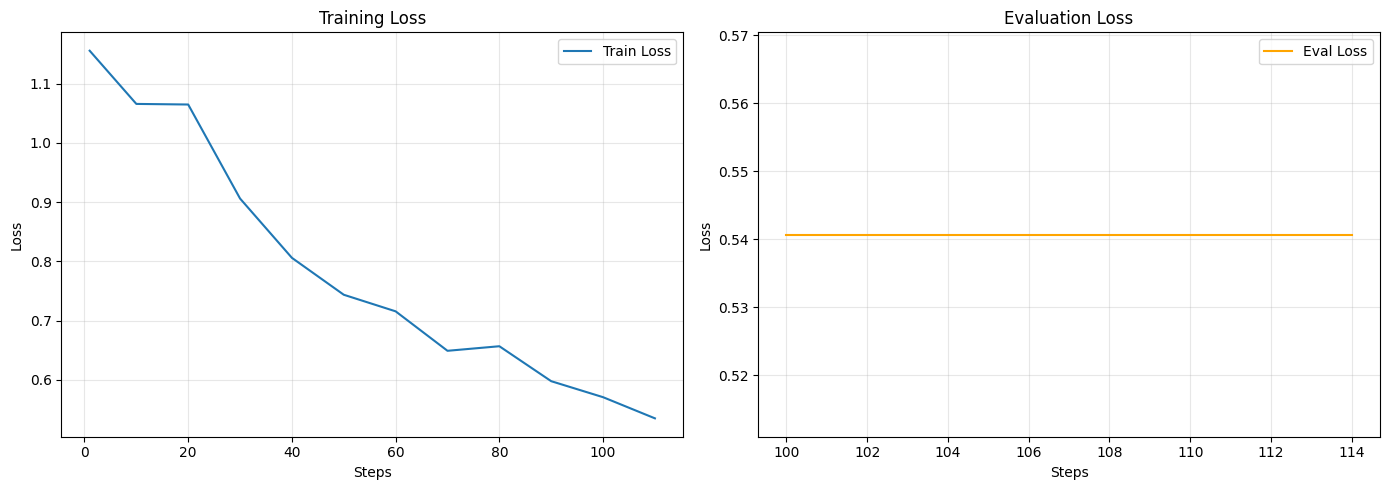

Training curves saved to /content/drive/MyDrive/synthetic-instruction-tuner/evaluation/figures/sft_training_curves.png


In [33]:
import matplotlib.pyplot as plt
import pandas as pd

# Load training logs
log_history = trainer.state.log_history

# Extract train and eval losses
train_logs = [log for log in log_history if 'loss' in log]
eval_logs = [log for log in log_history if 'eval_loss' in log]

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training loss
if train_logs:
    steps = [log['step'] for log in train_logs]
    losses = [log['loss'] for log in train_logs]
    axes[0].plot(steps, losses, label='Train Loss')
    axes[0].set_xlabel('Steps')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

# Evaluation loss
if eval_logs:
    steps = [log['step'] for log in eval_logs]
    losses = [log['eval_loss'] for log in eval_logs]
    axes[1].plot(steps, losses, label='Eval Loss', color='orange')
    axes[1].set_xlabel('Steps')
    axes[1].set_ylabel('Loss')
    axes[1].set_title('Evaluation Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{config['paths']['evaluation_figures']}/sft_training_curves.png", dpi=150)
plt.show()

print(f"Training curves saved to {config['paths']['evaluation_figures']}/sft_training_curves.png")

In [34]:
# Save efficiency metrics for comparison
METRICS_DIR = f"{PROJECT_ROOT}/evaluation/metrics"
os.makedirs(METRICS_DIR, exist_ok=True)

# Get summary
summary = tracker.get_summary()

# Add training results
summary["train_loss"] = train_result.training_loss
summary["eval_loss"] = eval_results["eval_loss"]

# Save
tracker.save(f"{METRICS_DIR}/lora_metrics.json")

print("\n=== LoRA Efficiency Metrics Summary ===")
for key, value in summary.items():
    if isinstance(value, float):
        print(f"  {key}: {value:.4f}")
    else:
        print(f"  {key}: {value}")

Metrics saved to /content/drive/MyDrive/synthetic-instruction-tuner/evaluation/metrics/lora_metrics.json

=== LoRA Efficiency Metrics Summary ===
  method: lora_r8
  trainable_params: 12156928
  total_params: 1815620608
  trainable_ratio_percent: 0.6696
  peak_memory_gb: 5.3088
  training_time_hours: 0.1369
  inference_tokens_per_sec: 7.6954
  train_loss: 0.7481
  eval_loss: 0.5407


## 13. Cleanup

In [35]:
# Free GPU memory
del model
del trainer
gc.collect()
torch.cuda.empty_cache()

print("Memory cleared!")

Memory cleared!


## ✓ SFT Training Complete!

### Summary:
- Fine-tuned model saved to `models/sft/final/`
- LoRA adapters trained with parameter-efficient fine-tuning
- Training configuration and metrics saved

### Model Loading:
To load the fine-tuned model later:
```python
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel

base_model = AutoModelForCausalLM.from_pretrained(BASE_MODEL_ID)
model = PeftModel.from_pretrained(base_model, FINAL_MODEL_DIR)
tokenizer = AutoTokenizer.from_pretrained(FINAL_MODEL_DIR)
```

### Next Steps:
1. Proceed to `06_dpo_training.ipynb` for DPO alignment
2. This will further improve the model using preference data

### Training Stats (A100):
- **Training time**: 2-4 hours
- **Cost**: ~10-21 compute units
- **Batch size**: 12 (effective: 24)
- **Total steps**: ~112
- **Precision**: BF16 + TF32